# AI-Driven Equipment Maintenance - Model Selection

**Purpose:** Experiment with various models, compare different AI&ML learning algorithms, architectures and configurations to determine which one performs best for our maintenance project.


**Automated ML:** provides tools to automatically discover good learning models for a dataset with little user intervention.

Key Features:

- Data Preprocessing:- Automatically handles tasks like cleaning, feature selection, and feature engineering.

- Model Selection:- Chooses the best algorithm for your data, whether it's classification, regression, clustering, etc.

- Hyperparameter Optimization:- Tunes the parameters of the selected model to achieve optimal performance.

- Pipeline Automation:- Creates end-to-end workflows, including data preprocessing, model training, and evaluation.

- Scalability:- Some AutoML tools are designed to handle large datasets and integrate with distributed systems.

This project uses the scikit-learn algorithm cheat-sheet to define/create initial model (baseline).

The AutoML libraries selected for our project are: H2O AutoML and AutoGluon for comparison between baseline and each other.



# Scikit-learn algorithm cheat-sheet

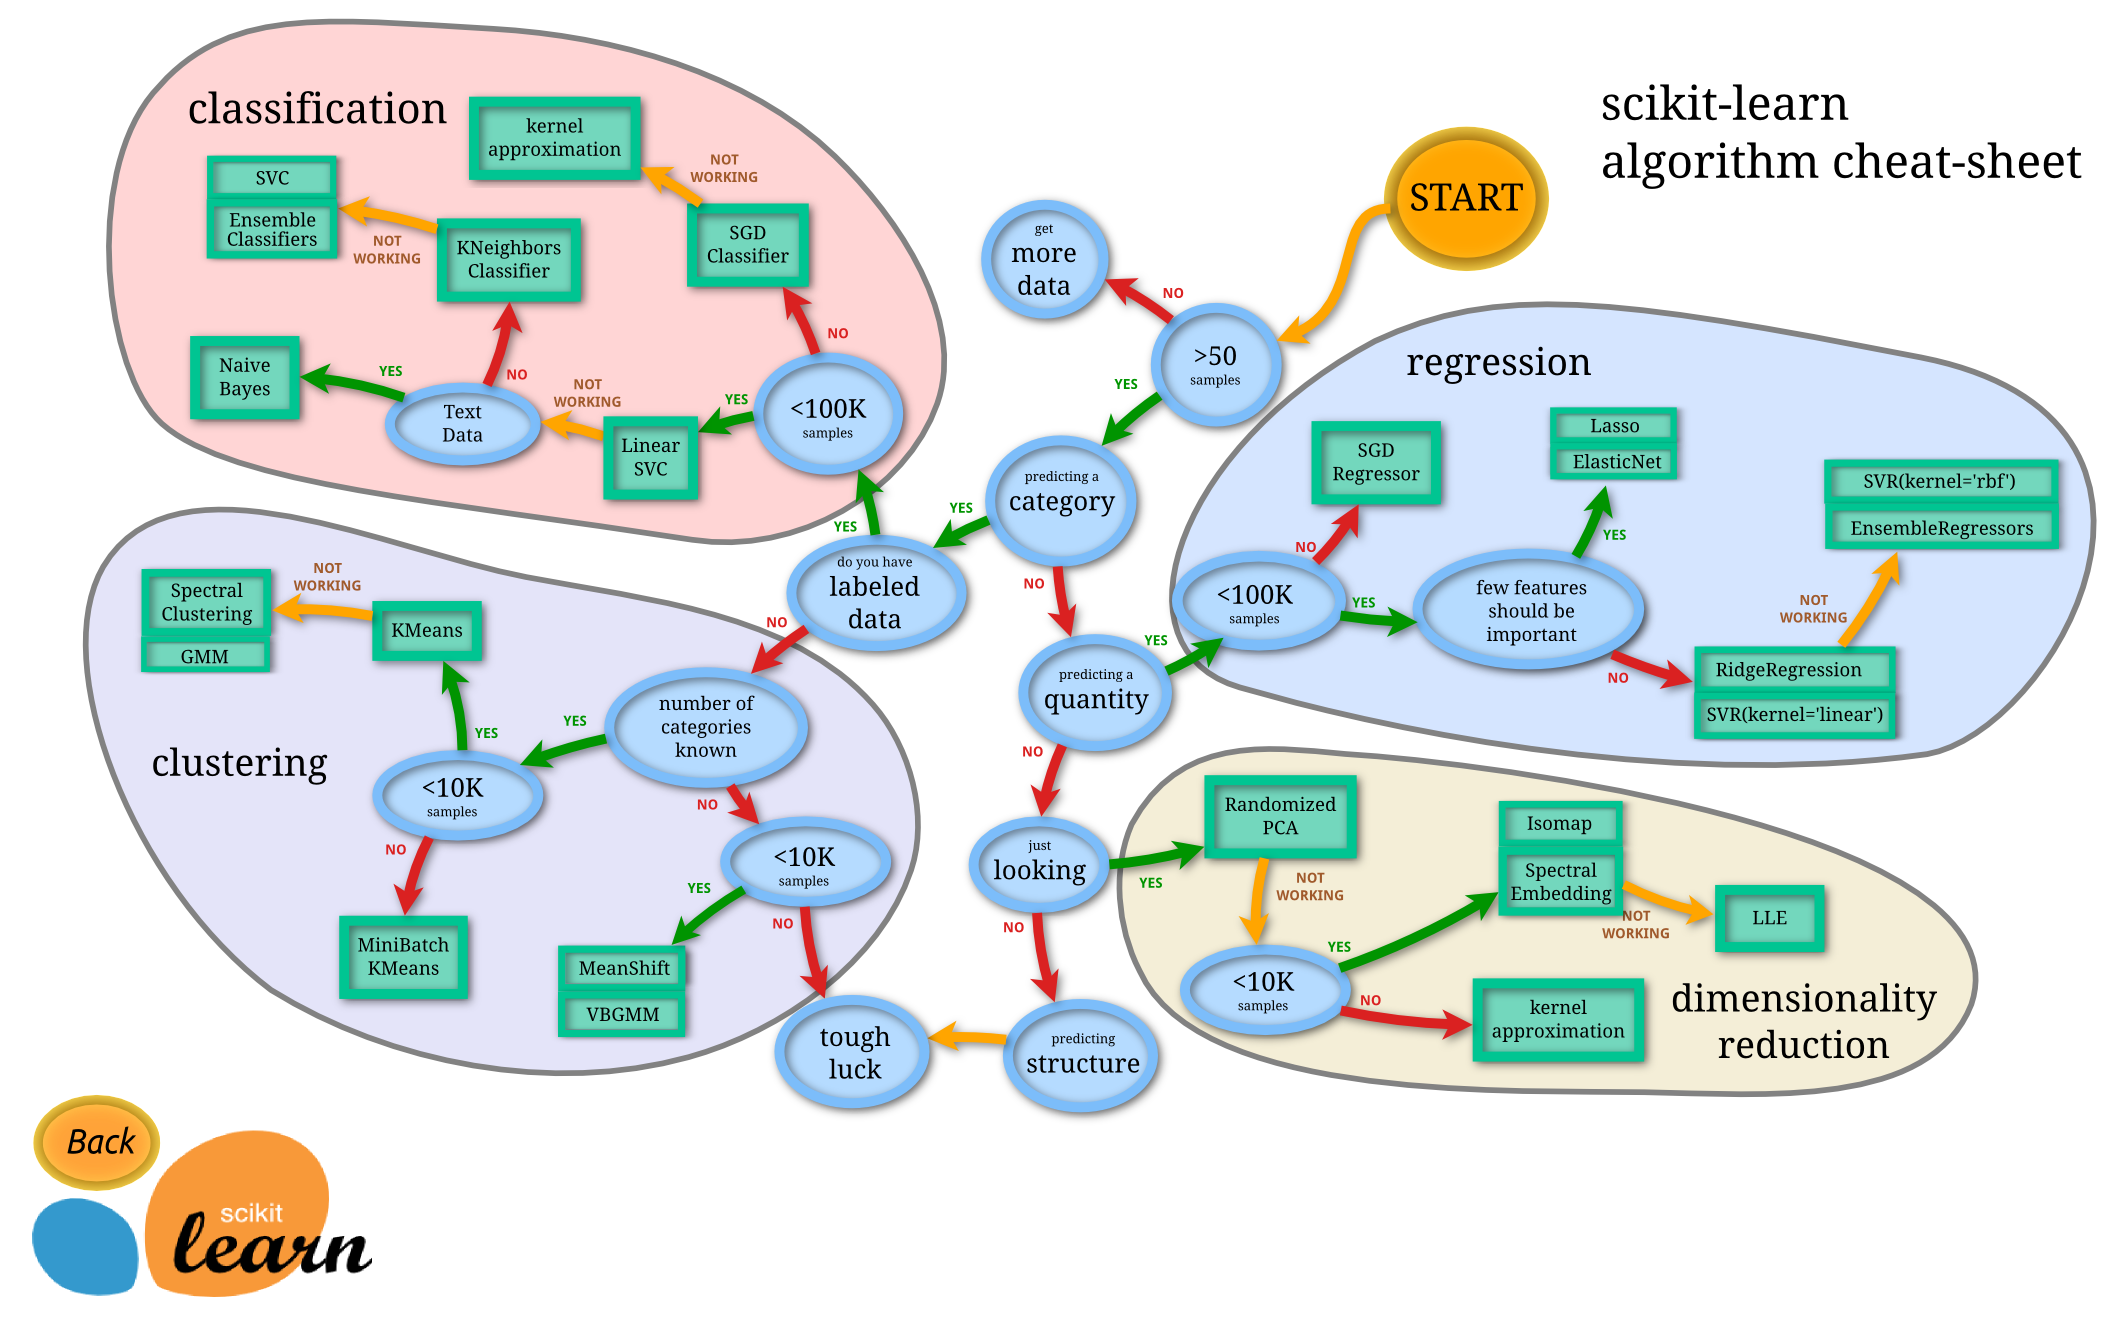

Flowchart:

Start: >50 samples? --YES-- predicting a category? --YES-- do you have labeled data? --YES-- <100K? --YES-- Linear SVM

From: https://scikit-learn.org/stable/modules/svm.html#classification

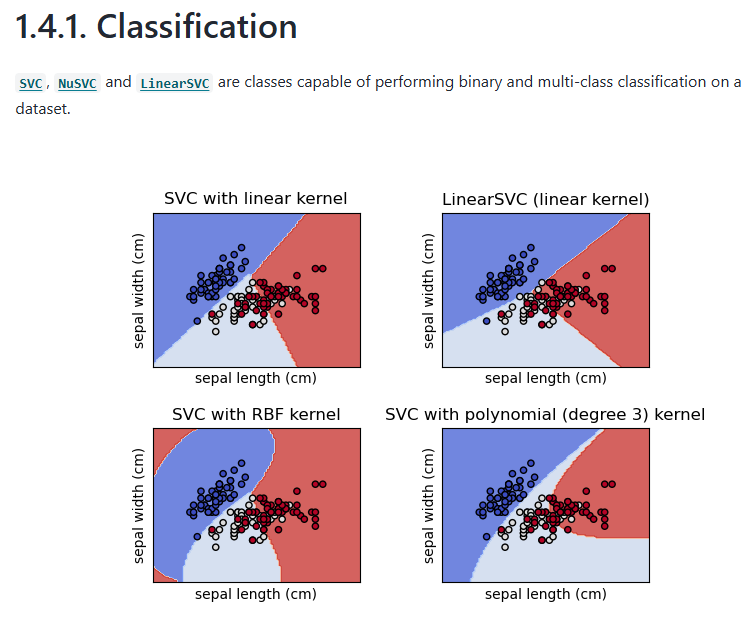

# Baseline Model - SVC (Support Vector Classifier) Model

Per the scikit-learn algorithm cheat-sheet, an SVC baseline model is used to address our binary classification task.

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import joblib

In [ ]:
#Load dataset
svcdf = pd.read_csv("AI4I 2020 Predictive Maintenance Dataset.csv")
svcdf.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [ ]:
# Drop irrelevant columns
svcdf = svcdf.drop(columns=["UDI", "Product ID"])

# Define features (X) and target (y)
X = svcdf.drop(columns=["Target"])
y = svcdf["Target"]

In [ ]:
#Pre-processing data
categorical_columns = ["Type", "Failure Type"]
numerical_columns = X.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Create pre-processing steps
preprocessor = ColumnTransformer(transformers=[("num", StandardScaler(), numerical_columns), ("cat", OneHotEncoder(drop="first"), categorical_columns)])

**Class imbalance:** occurs when the number of samples in one class is significantly higher (or lower) thant the others in a dataset. This imbalance can create challenges for machine learning models because the model becomes biased toward the majority class, reducing its abiltiy to correctly predict the minority class.

For the pipeline built, "class_wight = balanced" is to use to adjust the weights assigned to each class and handle class imbalance in the dataset.

In [ ]:
# Build pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor),  ("classifier", SVC(kernel="linear", C=1.0, class_weight = "balanced", random_state=42))])

In [ ]:
#Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Air temperature [K]',
                                                   'Process temperature [K]',
                                                   'Rotational speed [rpm]',
                                                   'Torque [Nm]',
                                                   'Tool wear [min]']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Type', 'Failure Type'])])),
                ('classifier',
                 SVC(class_weight='balanced', kernel='linear',
                     random_state=42))])

In [ ]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%" + "\n")

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


#Print ROC AUC scores
decision_scores = pipeline.decision_function(X_test)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, decision_scores)
print(f"ROC AUC Score: {roc_auc:.4f}")

Accuracy: 99.92%

Confusion Matrix:
[[2428    0]
 [   2   70]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2428
           1       1.00      0.97      0.99        72

    accuracy                           1.00      2500
   macro avg       1.00      0.99      0.99      2500
weighted avg       1.00      1.00      1.00      2500

ROC AUC Score: 0.9949


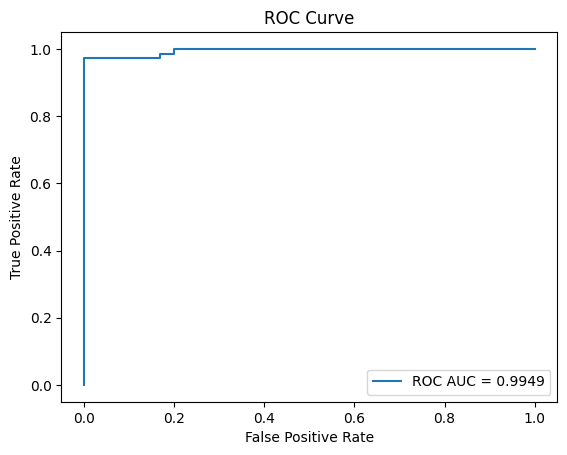

In [ ]:
import matplotlib.pyplot as plt

# Compute ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, decision_scores)

# Plot the ROC Curve
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
#Evaluate on train and test set
print("Training Accuracy:", pipeline.score(X_train, y_train))
print("Test Accuracy:", pipeline.score(X_test, y_test))

Training Accuracy: 0.9990666666666667
Test Accuracy: 0.9992


In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.9995 0.999  1.     0.998  0.999 ]
Mean CV Accuracy: 0.9991


**Overfitting:** Comparisong between training/testing accuracy and cross validations are used to confirm that overfitting is not present in model, due to the remarkably high accuracy and confusion matrix results without optimization. The results suggest that data is suitable/accurate and overfitting is not present in the model.

In [ ]:
#Save model
joblib.dump(pipeline, "svm_model.pkl")

['svm_model.pkl']

# H2O AutoML Model

In [ ]:
!pip install h2o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 4.2 MB/s eta 0:00:00


In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9h9ce3hy
  JVM stdout: /tmp/tmp9h9ce3hy/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp9h9ce3hy/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_unknownUser_oq2gwv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
data = h2o.import_file('AI4I 2020 Predictive Maintenance Dataset.csv')

# Drop irrelevant columns
data = data.drop(["\ufeffUDI", "Product ID"])

# Define features and target
x = data.columns[:-2]
y = "Target"
data.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
M,298.1,308.6,1551,42.8,0,0,No Failure
L,298.2,308.7,1408,46.3,3,0,No Failure
L,298.1,308.5,1498,49.4,5,0,No Failure
L,298.2,308.6,1433,39.5,7,0,No Failure
L,298.2,308.7,1408,40,9,0,No Failure
M,298.1,308.6,1425,41.9,11,0,No Failure
L,298.1,308.6,1558,42.4,14,0,No Failure
L,298.1,308.6,1527,40.2,16,0,No Failure
M,298.3,308.7,1667,28.6,18,0,No Failure
M,298.5,309,1741,28,21,0,No Failure


In [ ]:
#Categorical Encoding
data["Type"] = data["Type"].asfactor()
data["Failure Type"] = data["Failure Type"].asfactor()
data["Target"] = data["Target"].asfactor()

In [ ]:
#Train/Test split
train, test = data.split_frame(ratios=[0.8], seed=42)

In [ ]:
# Initialize AutoML
aml = H2OAutoML(max_runtime_secs=360, seed=42)

# Train AutoML
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [ ]:
#Evaluate performance

# Predict on the test set
predictions = aml.leader.predict(test)

# Check accuracy (for classification tasks)
accuracy = (predictions["predict"] == test[y]).mean()[0]
print(f"Test Accuracy: {accuracy}")

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Test Accuracy: 0.9893939393939394


In [ ]:
import os

# Get current working directory
current_dir = os.getcwd()

# Define the custom name for the model
custom_name = "AI-Driven-Equipment-Maintenance-H2O-Model.zip"

# Save the model with the custom name
model_path = h2o.save_model(model=aml.leader, path=os.path.join(current_dir, custom_name), force=True)

print(f"Model saved at: {model_path}")

Model saved at: /content/AI-Driven-Equipment-Maintenance-H2O-Model.zip/StackedEnsemble_BestOfFamily_4_AutoML_1_20250501_35029


In [ ]:
#Print results
print(aml.leaderboard)

performance = aml.leader.model_performance(test)
print(performance)

print(aml.leader.base_models)

model_id                                                     auc    logloss     aucpr    mean_per_class_error      rmse        mse
StackedEnsemble_BestOfFamily_4_AutoML_1_20250501_35029  0.974679  0.0486678  0.818555                0.159796  0.110257  0.0121565
StackedEnsemble_AllModels_3_AutoML_1_20250501_35029     0.97418   0.0478724  0.825196                0.133427  0.108739  0.0118241
StackedEnsemble_BestOfFamily_3_AutoML_1_20250501_35029  0.972588  0.0526898  0.791027                0.169661  0.115061  0.0132391
StackedEnsemble_AllModels_2_AutoML_1_20250501_35029     0.972056  0.0523907  0.792766                0.155116  0.11383   0.0129572
StackedEnsemble_AllModels_1_AutoML_1_20250501_35029     0.971938  0.0523195  0.79477                 0.155503  0.114267  0.0130568
GBM_grid_1_AutoML_1_20250501_35029_model_8              0.971681  0.0542944  0.798264                0.172781  0.114608  0.013135
XGBoost_grid_1_AutoML_1_20250501_35029_model_13         0.970957  0.0532092  0.79755

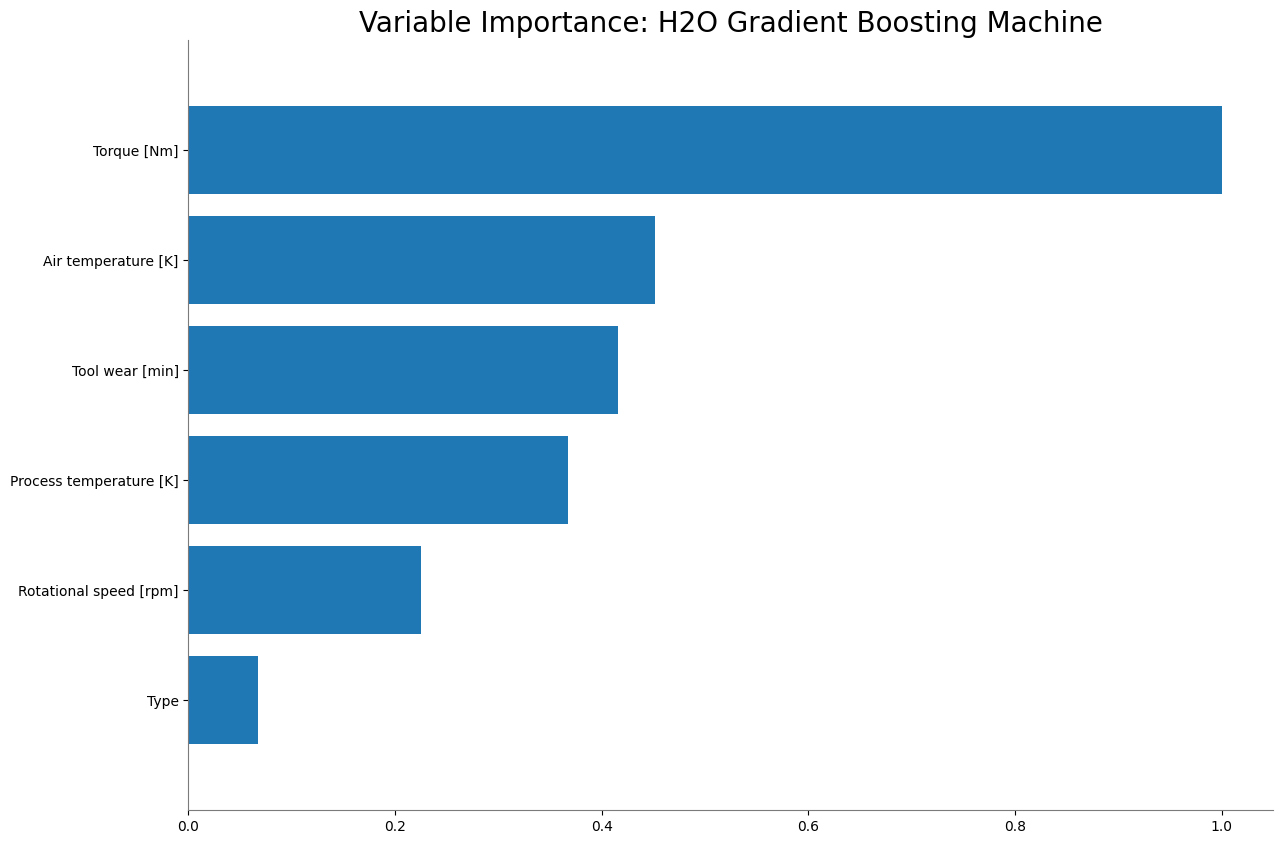

<Figure size 640x480 with 0 Axes>

In [ ]:
base_model = h2o.get_model("GBM_grid_1_AutoML_1_20250501_35029_model_8")
base_model.varimp_plot()

# AutoGluon Model

In [ ]:
!pip install autogluon.tabular

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

In [ ]:
# Load dataset
gln = pd.read_csv("AI4I 2020 Predictive Maintenance Dataset.csv")

# Drop irrelevant columns (example: "UDI", "Product ID")
gln = gln.drop(columns=["UDI", "Product ID"])

# Define features (X) and target (y)
X = gln.drop(columns=["Target"])  # Replace "Target" with your target column name
y = gln["Target"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Combine training features and target into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type,Target
4901,M,303.6,312.3,1630,32.4,223,No Failure,0
4375,L,302.0,309.7,1414,36.3,209,No Failure,0
6698,L,301.6,310.8,1418,44.7,46,No Failure,0
9805,L,298.4,309.2,1651,28.5,141,No Failure,0
1101,H,296.7,307.5,1607,33.6,38,No Failure,0


In [ ]:
# Train an AutoGluon model
predictor = TabularPredictor(label="Target", problem_type="binary").fit(train_data=train_data, presets="best_quality", time_limit=600)


No path specified. Models will be saved in: "AutogluonModels/ag-20250501_035839"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       9.67 GB / 12.67 GB (76.3%)
Disk Space Avail:   74.52 GB / 112.64 GB (66.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fi

In [ ]:
# Display leaderboard of models
leaderboard = predictor.leaderboard(silent=True)
print(leaderboard)

                          model  score_val eval_metric  pred_time_val  \
0               LightGBM_BAG_L1   0.999067    accuracy       0.036001   
1                XGBoost_BAG_L1   0.999067    accuracy       0.041667   
2           WeightedEnsemble_L2   0.999067    accuracy       0.043010   
3     NeuralNetTorch_r79_BAG_L1   0.999067    accuracy       0.098209   
4        NeuralNetFastAI_BAG_L1   0.999067    accuracy       0.169633   
5       RandomForestGini_BAG_L1   0.999067    accuracy       0.201990   
6   NeuralNetFastAI_r191_BAG_L1   0.999067    accuracy       0.219451   
7         ExtraTreesGini_BAG_L1   0.999067    accuracy       0.228296   
8         ExtraTreesEntr_BAG_L1   0.999067    accuracy       0.231466   
9         ExtraTrees_r42_BAG_L1   0.999067    accuracy       0.321258   
10            LightGBMXT_BAG_L2   0.999067    accuracy       2.331570   
11        NeuralNetTorch_BAG_L2   0.999067    accuracy       2.473742   
12       NeuralNetFastAI_BAG_L2   0.999067    accur

In [ ]:
# Evaluate metrics
evaluation_results = predictor.evaluate(test_data)

# Print evaluation results
print(evaluation_results)

{'accuracy': 0.9992, 'balanced_accuracy': np.float64(0.9861111111111112), 'mcc': np.float64(0.98560744686882), 'roc_auc': np.float64(0.9860767893099031), 'f1': np.float64(0.9859154929577465), 'precision': np.float64(1.0), 'recall': np.float64(0.9722222222222222)}


In [ ]:
#Confusion Matrix
y_true = test_data["Target"]
y_pred = predictor.predict(test_data)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2428    0]
 [   2   70]]


In [ ]:
# Save the trained model
predictor.save("autogluon_model")

# Result Comparison

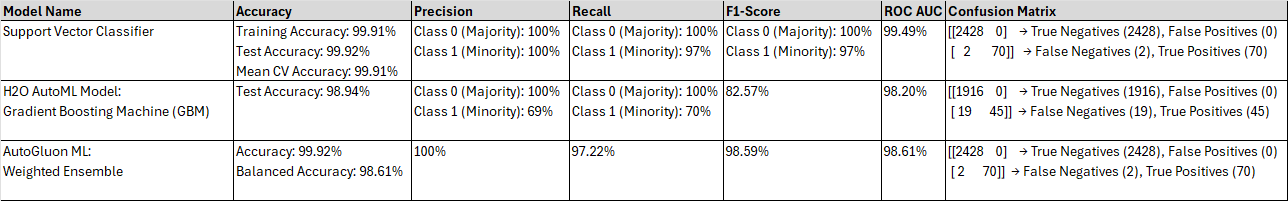

Both the SVC and the Weighted Ensembled (AutoGluon) models are good choices for the AI-Driven Equipment Maintenance solution with nearly identical results.

- Both have high accuracy, precision and recall values for the minority class.

- Both have high F1-scores and handle class imbalance effectively.

- Both have high ROC AUC values, therefore distinguish well between majority and minority classes.

Moving forward, the Support Vector Classifier Model will be used to make predictions due to slightly higher ROC AUC value and for simplicity and resource efficiency. In addition, optimization and hyperparameter tuning can still further improve the model.